# Iris データセットの分類

http://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html

[花びらの長さ、花びらの幅、がくの長さ、がくの幅]の4つの特徴から

[セトサ、ヴァージカラー、ヴァージニカ]の3種のアヤメを分類する

（機械学習分野の練習問題）

In [19]:
#ライブラリのロード
import numpy as np
import chainer
from chainer import cuda, Function, gradient_check, report, training, utils, Variable
from chainer import datasets, iterators, optimizers, serializers
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L
from chainer.training import extensions
from chainer.dataset import concat_examples
import inspect
from jupyterthemes import jtplot
jtplot.style()
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import pyplot as plt
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import sklearn.datasets
from mylib.PlotUtil import PlotLossAndAccuracy, PlotTupleDataSet, generate_cmap

#ライブラリで用意されているデータセットのロード
data = sklearn.datasets.load_iris()

In [20]:
data.feature_names
data.data[0:5]
data.target_names
data.target[0:5]

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

array([[ 5.1,  3.5,  1.4,  0.2],
       [ 4.9,  3. ,  1.4,  0.2],
       [ 4.7,  3.2,  1.3,  0.2],
       [ 4.6,  3.1,  1.5,  0.2],
       [ 5. ,  3.6,  1.4,  0.2]])

array(['setosa', 'versicolor', 'virginica'],
      dtype='<U10')

array([0, 0, 0, 0, 0])

データセットには4つの特徴の値と名前、種IDと種名が入っている

## データセットの解析

分類を始める前にデータがどのような分布になっているのか見る

x - 花びらの長さ 
y - 花びらの幅


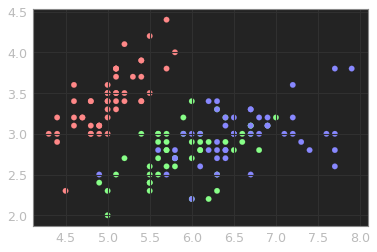

x - 花びらの長さ 
y - がくの長さ


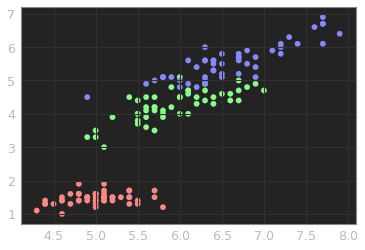

x - 花びらの長さ 
y - がくの幅


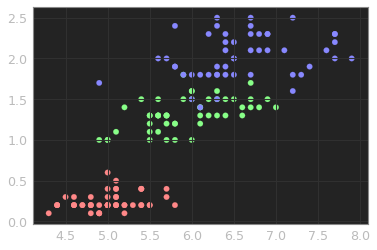

x - 花びらの幅 
y - がくの長さ


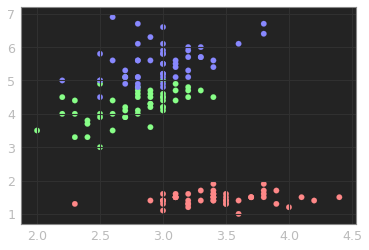

x - 花びらの幅 
y - がくの幅


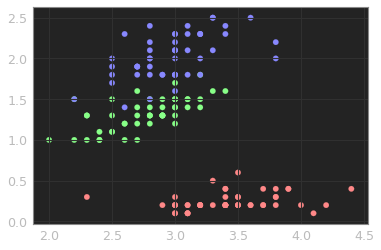

x - がくの長さ 
y - がくの幅


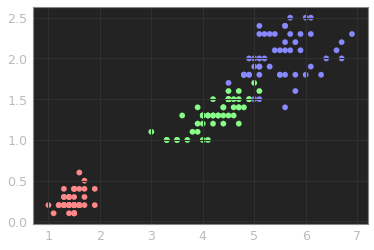

In [21]:
#正規化してないのでデータセットにはできないが、表示の簡便化のためとりあえずTupleDatasetにする
dataset = datasets.TupleDataset(data.data, data.target)

feat = ['花びらの長さ', '花びらの幅', 'がくの長さ', 'がくの幅']

for i in range(4):
    for j in range(4):
        if not j > i: continue        
        print("x -",feat[i],"\ny -", feat[j])
        PlotTupleDataSet(dataset, ["#FF8888", "#88FF88", "#8888FF"], i, j)
        plt.show()
        

## データの前処理

データは正規化されていないので正規化する

今回はそれぞれの特徴で、(値-最小値)/(最大値-最小値)で全てのデータを[0,1]におさめる

各特徴の最大値-最小値の出し方を以下に示す

In [22]:
maxs = np.max(data.data, axis=0)
mins = np.min(data.data, axis=0)
scales = maxs - mins

maxs
mins
scales

array([ 7.9,  4.4,  6.9,  2.5])

array([ 4.3,  2. ,  1. ,  0.1])

array([ 3.6,  2.4,  5.9,  2.4])

この時、scalesが各特徴での最大値-最小値を表す

In [23]:
data.data = (data.data-mins)/scales

#正規化結果を一部表示
data.data[0:5]

array([[ 0.22222222,  0.625     ,  0.06779661,  0.04166667],
       [ 0.16666667,  0.41666667,  0.06779661,  0.04166667],
       [ 0.11111111,  0.5       ,  0.05084746,  0.04166667],
       [ 0.08333333,  0.45833333,  0.08474576,  0.04166667],
       [ 0.19444444,  0.66666667,  0.06779661,  0.04166667]])

## モデルの用意

今回はSimpleModel（Chainer Sample MNIST と同じ）を使う

In [44]:
#モデルを用意
class SimpleModel(Chain):
    def __init__(self, n_out):
        super(SimpleModel, self).__init__()
        with self.init_scope():
            self.l1 = L.Linear(None, 100)
            self.l2 = L.Linear(None, 100)
            self.l3 = L.Linear(None, n_out)
    
    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        y = self.l3(h2)
        return y

## データセット前処理

もともとのデータセットを学習用とテスト用に分けるなどのデータ前処理を行う

In [45]:
# datasetのデフォルトはfloat64のnumpy.ndarrayなので計算用に型変換する
dataset = datasets.TupleDataset(data.data.astype(np.float32), data.target)
#テストデータは全体の1/4程度とする
test_len = int(len(dataset)/4)
print("test dataset length:",test_len)

test, train = datasets.split_dataset_random(dataset, test_len)

batch_size = 5

train_iter = iterators.SerialIterator(train, batch_size)
test_iter = iterators.SerialIterator(test, batch_size, False, False)

test dataset length: 37


## trainerの作成・学習

chainerに用意されている、学習ループの抽象化クラスtrainerを用いて学習を行う

学習ループを逐一書くよりコード量が少なく、エポックごとのloss/accuracyのファイル出力も自動化される


In [46]:
def GetTrainerForModel(model, train_iter, test_iter, stop_epoch, log_name):
        optimizer = optimizers.Adam()
        classifier = L.Classifier(model)
        optimizer.setup(classifier)
        updater = training.StandardUpdater(train_iter, optimizer)
        trainer = training.Trainer(updater, (stop_epoch, 'epoch'))
        
        trainer.extend(extensions.Evaluator(test_iter, classifier))
        trainer.extend(extensions.LogReport(log_name=log_name))
        #以下のコメントアウトを外すとtrainer.run()時に実行過程がコンソールへ出力される
#        trainer.extend(extensions.PrintReport(['epoch', 'main/accuracy', 'main/loss', 'elapsed_time']))
        return trainer

model = SimpleModel(3)

trainer = GetTrainerForModel(model, train_iter, test_iter, 200, 'trainLog_Iris')

In [47]:
#学習スタート
train_iter.reset()
test_iter.reset()
trainer.run()

result/trainLog_Iris
2017-11-16 19:39:18


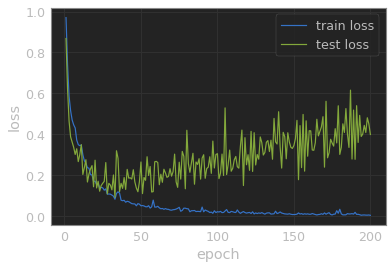

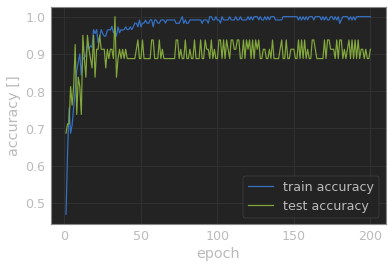

In [48]:
PlotLossAndAccuracy('result', 'trainLog_Iris')